# Circuit Generation

In this notebook, we demonstrate how to generate a pool of equivalent circuit models from electrochemical impedance spectroscopy (EIS) measurements that best fit the data.

## Set up the environment

AutoEIS relies on `EquivalentCircuits.jl` package to perform the EIS analysis. The package is not written in Python, so we need to install it first. AutoEIS ships with `julia_helpers` module that helps to install and manage Julia dependencies with minimal user interaction. For convenience, installing Julia and the required packages is done automatically when you import `autoeis` for the first time. If you have Julia installed already (discoverable in system PATH), it'll get detected and used, otherwise, it'll be installed automatically.

<div class="alert alert-info">

Note

If this is the first time you're importing AutoEIS, executing the next cell will take a while, outputting a lot of logs. Re-run the cell to get rid of the logs.

</div>

In [1]:
import matplotlib.pyplot as plt

import autoeis as ae

ae.visualization.set_plot_style()

## Load EIS data

Once the environment is set up, we can load the EIS data. You can use [`pyimpspec`](https://vyrjana.github.io/pyimpspec/guide_data.html) to load EIS data from a variety of popular formats. Eventually, AutoEIS requires two arrays: `Z` and `freq`. `Z` is a complex impedance array, and `freq` is a frequency array. Both arrays must be 1D and have the same length. The impedance array must be in Ohms, and the frequency array must be in Hz.

For convenience, we provide a function `load_test_dataset()` in `autoeis.io` to load a test dataset. The function returns a tuple of `freq` and `Z`.

In [2]:
freq, Z = ae.io.load_test_dataset(preprocess=True)

[22:06:19] WARNING  10% of data filtered out.                                   


<div class="alert alert-info">

Note

If your EIS data is stored as text, you can easily load them using `numpy.loadtxt`. See NumPy's documentation for more details.

</div>

Let's take a look at the test dataset before we proceed:

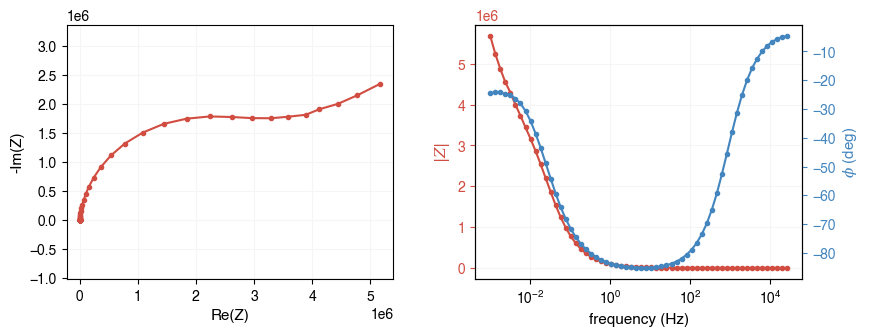

In [3]:
ae.visualization.plot_impedance_combo(freq, Z);

## Generate equivalent circuits

Now that we have loaded the EIS data, we can generate a pool of candidate equivalent circuits using the `generate_equivalent_circuits` function. The function takes the impedance data and frequency as input and returns a list of equivalent circuits. It also takes many optional arguments to control the circuit generation process. The most important ones are:

- `iters`: Number of circuits to generate.
- `complexity`: Maximum number of elements in a circuit.
- `terminals`: Type of circuit components to use (e.g., R, C, L, or P).
- `parallel`: Whether to run the circuit generation in parallel.
- `tol`: Tolerance for accepting a circuit as a good fit.

The function uses a gene expression programming (GEP) algorithm to generate the circuits. The GEP algorithm is a genetic algorithm that evolves circuits by combining and mutating genes. The algorithm starts with a population of random circuits and evolves them over many generations to find the best circuits that fit the data. The following parameters control the GEP algorithm:

- `generations`: Number of generations to run the genetic algorithm.
- `population_size`: Number of circuits in the population for

The default values for these parameters are usually good enough for most cases. However, you can adjust them to get better results (e.g., increase both arguments if you're not satisfied with the generated circuits, or decrease them if you want to speed up the process).

<div class="alert alert-info">

Note

Circuit generation is a lengthy process. It may take one minute per iteration on a modern CPU. We recommend generating at least 50 circuits to get a good pool of candidate circuits, which may take about an hour.

</div>

<div class="alert alert-info">

Note

By default, `terminals` is set to `"RLP"`, i.e., the algorithm searches for circuits with resistors, inductors, and constant-phase elements. You can add capacitors by setting `terminals="RCLP"`, but since a capacitor is a special case of a constant-phase element, it's not necessary, and it makes the search less efficient.

</div>

In [4]:
kwargs = {
    "iters": 12,
    "complexity": 12,
    "population_size": 100,
    "generations": 30,
    "terminals": "RLP",
    "tol": 1e-3,
    "parallel": True,
}
circuits_unfiltered = ae.core.generate_equivalent_circuits(freq, Z, **kwargs)
circuits_unfiltered

Generating Candidate ECMs:   0%|          | 0/12 [00:00<?, ?it/s]

,circuitstring,Parameters
0,"[L1,R2]-[P3,[P4,R5]-R6]","{'L1': 0.16036630587630044, 'R2': 139.58743322..."
1,"[P1,P2]-P3-R4","{'P1w': 4.0685666164516736e-07, 'P1n': 0.16597..."
2,"[L1,R2]-[P3,P4]","{'L1': 5.0, 'R2': 141.97367403517057, 'P3w': 4..."
3,"[P1-R2-L3,[R4-P5,R6]]","{'P1w': 2.2714814578960026e-06, 'P1n': 0.40141..."
4,"P1-[R2,P3]-[P4,R5]","{'P1w': 0.006695886148448849, 'P1n': 0.0058691..."
5,"P1-P2-[R3,[P4,[P5,R6]]]","{'P1w': 6.785933453948513e-05, 'P1n': 0.844719..."
6,"[P1-R2,[P3,R4]]","{'P1w': 1.737289508823279e-06, 'P1n': 0.962391..."
7,"[[R1-P2,P3-R4]-P5,R6]","{'R1': 139.15408437848245, 'P2w': 2.0058849990..."


<div class="alert alert-warning">

Convergence

The Circuit generation algorithm is sensitive to the `tol` parameter, meaning that the order of magnitude of the `tol` needs to be proportional to the order of magnitude of the impedance data. There's no one-size-fits-all value for `tol`, and we're trying to make the algorithm `tol`-agnostic in future releases. For now, we've hacked a heuristic that internally scales the `tol` based on the impedance data. Nevertheless, you may still need to adjust the `tol` if you end up with no circuits (increase `tol`) or too many circuits (decrease `tol`). The default value is `1e-3`. When increasing or decreasing `tol`, try doubling or halving the value to see if it helps.

</div>

## Filter candidate equivalent circuits

Note that all these circuits generated by the GEP process probably fit the data well, but they may not be physically meaningful. Therefore, we need to filter them to find the ones that are most plausible. AutoEIS uses "statistical plausibility" as a proxy for gauging "physical plausibility". To this end, AutoEIS provides a function to filter the candidate circuits based on some heuristics (read our [paper](https://doi.org/10.1149/1945-7111/aceab2) for the exact steps and the supporting rationale).

In [5]:
circuits = ae.core.filter_implausible_circuits(circuits_unfiltered)
circuits

,circuitstring,Parameters
0,"[P1,P2]-P3-R4","{'P1w': 4.0685666164516736e-07, 'P1n': 0.16597..."


Let's see how well the generated circuits fit the data. You can either use the parameters' values at the end of the GEP process (stored in the `circuits` dataframe), or use `fit_circuit_parameters` to further refine the parameters (recommended).

<div class="alert alert-info">

Note

Normally, the found circuits are good enough, but since we didn't run the algorithm for long enough (to not timeout our CI on GitHub), we will use a custom circuit for evaluation. If you're running this notebook on your own data, try using `iters >= 200` together with a more stringet `tol` to get a good pool of circuits. We're currently working on changing the evolutionary algorithm backend to speed up the process, so you no longer need to wait for hours to get a good pool of circuits.

</div>

Text(0.5, 1.0, '[P1,P2]-P3-R4')

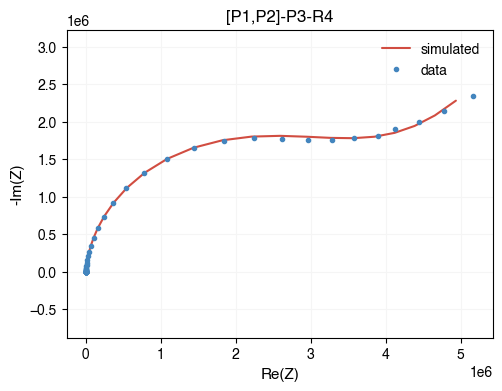

In [6]:
use_custom_circuit = False

if not use_custom_circuit:
    circuit = circuits.iloc[0]["circuitstring"]
    p = circuits.iloc[0]["Parameters"]
    # Refine the circuit parameters
    p = ae.utils.fit_circuit_parameters(circuit, freq, Z, p0=p)
else:
    circuit = "R4-[P1,R3-P2]"
    p = ae.utils.fit_circuit_parameters(circuit, freq, Z)

# Simulate Z using the circuit and the fitted parameters
circuit_fn = ae.utils.generate_circuit_fn(circuit)
Z_sim = circuit_fn(freq, list(p.values()))

# Plot against ground truth
fig, ax = plt.subplots(figsize=(5.5, 4))
ae.visualization.plot_nyquist(Z_sim, fmt="-", ax=ax, label="simulated")
ae.visualization.plot_nyquist(Z, fmt=".", ax=ax, label="data");
ax.set_title(circuit)